In [ ]:
import datasets
from src.models.components.partmae_v4 import PARTMaskedAutoEncoderViT, PART_mae_vit_base_patch16_dec512d8b
from src.data.components.transforms.multi_crop_v2 import ParametrizedMultiCropV2
from lightning import Fabric
from tqdm import tqdm
from torch import nn, Tensor
import torch
from torch.utils.data import Dataset, DataLoader, default_collate
from torchmetrics import MeanSquaredError, MeanMetric, MetricCollection
from PIL import Image
from lightning.fabric.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import math
import timm
import timm.scheduler
import torch.optim
import logging

logging.basicConfig(level=logging.INFO)

ModuleNotFoundError: No module named 'data.components'

## Overfit Training

In [ ]:
class HFDataset(Dataset):
    def __init__(
        self,
        dataset: str,
        name: str,
        split="train",
        img_key: str = "image",
        transform=None,
    ):
        self.ds = datasets.load_dataset(dataset, name, split=split)
        self.transform = transform
        self.img_key = img_key

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.ds[idx][self.img_key])
        return self.ds[idx]

In [ ]:
B = 16
gV = 1
lV = 5
V = gV + lV
train_transform = ParametrizedMultiCropV2(n_global_crops=gV, n_local_crops=lV)
dataset = HFDataset("frgfm/imagenette", "160px", transform=train_transform)
train_dataloader = DataLoader(dataset, batch_size=B, shuffle=False)

In [2]:
# overfit to a few batches

torch.set_float32_matmul_precision("medium")
logger = TensorBoardLogger("../../logs/tb_logs/imagenette/")
fabric = Fabric(precision="bf16-mixed", loggers=logger)

EPOCHS = 1
COMPILE = False

if EPOCHS < 3000:
    COMPILE = False

logging.info(f"Initializing model with {EPOCHS} epochs, compile={COMPILE}")
with fabric.init_module():
    model = PART_mae_vit_base_patch16_dec512d8b(
        sampler="stratified_jittered",
        alpha_ts=0.8,
        mask_ratio=0.75,
        pos_mask_ratio=0.75,
        alpha_t=0.75,
        max_scale_ratio=6.0,
        canonical_img_size=512,
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=8e-6)
    # cosine scheduler
    sched = timm.scheduler.CosineLRScheduler(
        optimizer, t_initial=EPOCHS, lr_min=9e-7, warmup_t=500, warmup_lr_init=9e-7
    )

if COMPILE:
    logging.info(f"Compiling model")
    model = torch.compile(model, fullgraph=True, dynamic=False)
    logging.info(f"Model compiled")

logging.info(f"Fabric setup")
model, optimizer = fabric.setup(model, optimizer)
dataloader = fabric.setup_dataloaders(train_dataloader)
logging.info(f"Fabric setup done")

global_step = 0
fabric.call("on_train_start", fabric)
logging.info(f"Started training")
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    fabric.call("on_train_epoch_start", fabric, global_step, optimizer)
    pbar = tqdm(dataloader, total=len(dataloader), description=f"Epoch: {epoch} Loss: null dt std: null")
    for batch in pbar:
        out = model(*batch)
        fabric.backward(out["loss"])
        optimizer.step()
        optimizer.zero_grad()
        fabric.call("on_train_batch_end", out)
        global_step += 1

    sched.step(epoch)
    fabric.call("on_train_epoch_end", fabric, global_step)
    metric_dict = metric_logger.get_current_metrics()
    pbar.set_description(
        f"Epoch: {epoch} Loss: {metric_dict['loss']:.4f} " f"dt std: {metric_dict['dt_std'] * 512:.4f}"
    )

fabric.save(f"imagenette_ep{EPOCHS}_B{B}_gV{gV}_lV{lV}.ckpt", state=model.state_dict())

NameError: name 'torch' is not defined

In [ ]:
EPOCHS=10000
state_dict = fabric.load(f"model_ep{EPOCHS}_B{B}_gV{gV}_lV{lV}.ckpt")
model.load_state_dict(state_dict)

<All keys matched successfully>

## Reconstruction

### Utils

In [ ]:
def clean_model_io(batch: tuple, out: dict, device="cuda"):
    """
    Cleans and reshapes model outputs for visualization.

    - Detach and move tensors to device.
    - Adds useful tensors to dict (crop_params, canonical_params)
    """
    io = dict()

    io["g_x"] = batch[0]
    io["g_params"] = batch[1]
    io["l_x"] = batch[2]
    io["l_params"] = batch[3]

    for pfx in ["g", "l"]:
        io[f"{pfx}_crop_params"] = io[f"{pfx}_params"][:, :, 4:8]  
    
    io[f"canonical_params"] = io[f"g_params"][:, 0, :4]

    io.update({name: out[name] for name in out.keys()})

    ## MOVE TO DEVICE and DETACH
    clean = lambda x: x.to(device).detach() if isinstance(x, Tensor) else x
    io = {name: clean(tensor) for name, tensor in io.items()}
    return io


In [ ]:
from src.utils.visualization.reconstruction_v4_gt import (
    reconstruction_gt,
)

def make_plots(
    reconstructed_img: Tensor, io: dict, batch_idx: int, original_img: Image.Image
):
    gt_reconstruction = reconstruction_gt(
        g_crops=io["g_x"][batch_idx],
        l_crops=io["l_x"][batch_idx],
        g_patch_positions_nopos=io["g_patch_positions_nopos"][batch_idx],
        l_patch_positions_nopos=io["l_patch_positions_nopos"][batch_idx],
        patch_size=16,
        canonical_img_size=512,
        g_shapes=io["g_shapes"],
        l_shapes=io["l_shapes"],
        g_crop_params=io["g_crop_params"][batch_idx],
        l_crop_params=io["l_crop_params"][batch_idx],
    )
    fig, axes = plt.subplots(1, 3)
    canonical_img = train_transform.recreate_canonical(
        original_img, io["canonical_params"][batch_idx].tolist()
    )
    axes[0].imshow(canonical_img)
    axes[0].set_title("Original")
    axes[1].imshow(gt_reconstruction.permute(1, 2, 0).cpu())
    axes[1].set_title("GT reconstruction")
    axes[2].imshow(reconstructed_img.permute(1, 2, 0).cpu())
    axes[2].set_title("Reconstruction")
    return fig, axes

##

## LR Finder

In [3]:
torch.set_float32_matmul_precision("medium")
B = 128
gV = 2
lV = 10
V = gV + lV
train_transform = ParametrizedMultiCropV2(n_global_crops=gV, n_local_crops=lV)
dataset = HFDataset("frgfm/imagenette", "160px", transform=train_transform)
train_dataloader = DataLoader(dataset, batch_size=B, shuffle=False)
model = PART_mae_vit_base_patch16_dec512d8b(
    sampler="stratified_jittered",
    alpha_ts=0.8,
    mask_ratio=0.75,
    pos_mask_ratio=0.75,
    alpha_t=0.75,
    max_scale_ratio=6.0,
    canonical_img_size=512,
)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)

In [4]:
from torch_lr_finder import LRFinder, TrainDataLoaderIter
from torch.utils.data import DataLoader, Dataset


class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, args):
        return self.model(*args)


class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch):
        return batch, None


def criterion(out, _):
    return out["loss"]


model = ModelWrapper(model)
custom_train_iter = CustomTrainIter(train_dataloader)
amp_config = {
    'device_type': 'cuda',
    'dtype': torch.bfloat16,
}
grad_scaler = torch.amp.GradScaler()
accumulation_steps = 8
full_views_per_batch = gV + lV * (96*96)/(224*224)
effective_batch_size = B * full_views_per_batch * accumulation_steps
print(f"Full views per batch: {full_views_per_batch}")
print(f"Effective batch size: {effective_batch_size}")


Full views per batch: 3.836734693877551
Effective batch size: 3928.816326530612


In [ ]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda", amp_backend="torch", amp_config=amp_config, grad_scaler=grad_scaler)
lr_finder.range_test(
    custom_train_iter,
    start_lr=5e-4,
    end_lr=1e-2,
    num_iter=30,
    step_mode="exp",
    accumulation_steps=accumulation_steps,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 9.39E-04


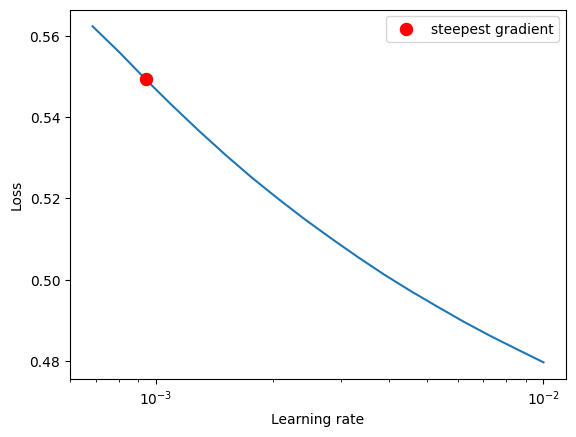

In [10]:
ax = lr_finder.plot(suggest_lr=True, skip_start=2, skip_end=0) # 3e-6
# add vline at 10